Using device: cpu
Epoch 1: Loss = 38.8078


C:\Users\jbkee\AppData\Local\Temp\ipykernel_14440\822878317.py:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [457 479] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\jbkee\AppData\Local\Temp\ipykernel_14440\822878317.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` i

Epoch 2: Loss = 26.7914
Epoch 3: Loss = 19.7364
Epoch 4: Loss = 14.3109
Epoch 5: Loss = 10.7957
Epoch 6: Loss = 7.8108
Epoch 7: Loss = 6.5896
Epoch 8: Loss = 3.9634
Epoch 9: Loss = 2.9061
Epoch 10: Loss = 1.8228
Epoch 11: Loss = 1.3806
Epoch 12: Loss = 1.0176
Epoch 13: Loss = 0.6679
Epoch 14: Loss = 0.5127
Epoch 15: Loss = 0.3978
Epoch 16: Loss = 0.3047
Epoch 17: Loss = 0.2535
Epoch 18: Loss = 0.2013
Epoch 19: Loss = 0.1740
Epoch 20: Loss = 0.1523
Epoch 21: Loss = 0.1348
Epoch 22: Loss = 0.1184
Epoch 23: Loss = 0.1072
Epoch 24: Loss = 0.0974
Epoch 25: Loss = 0.0861
Epoch 26: Loss = 0.0734
Epoch 27: Loss = 0.0671
Epoch 28: Loss = 0.0611
Epoch 29: Loss = 0.0550
Epoch 30: Loss = 0.0511
Epoch 31: Loss = 0.0456
Epoch 32: Loss = 0.0412
Epoch 33: Loss = 0.0383
Epoch 34: Loss = 0.0350
Epoch 35: Loss = 0.0344
Epoch 36: Loss = 0.0313
Epoch 37: Loss = 0.0302
Epoch 38: Loss = 0.0273
Epoch 39: Loss = 0.0264
Epoch 40: Loss = 0.0240
Epoch 41: Loss = 0.0235
Epoch 42: Loss = 0.0214
Epoch 43: Loss = 0.0

C:\Users\jbkee\AppData\Local\Temp\ipykernel_14440\822878317.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


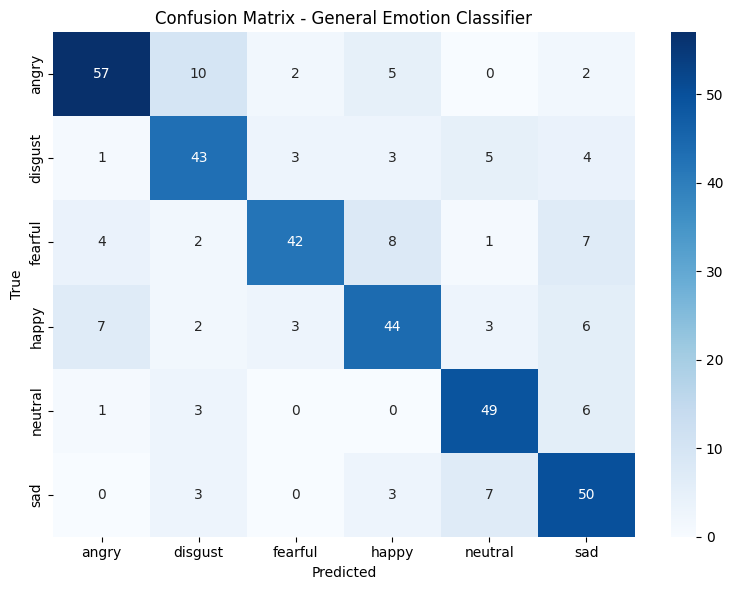

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils.multiclass import unique_labels
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

# Load a fresh copy
df = pd.read_csv("openSmile_emobase.csv")

# Encode emotion labels
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Select features + label
X = df.drop(columns=["emotion", "emotion_encoded", "filename"], errors="ignore")
y = df["emotion_encoded"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Device selection ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# MLP model
class MultiClassMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

general_model = MultiClassMLP(X_train.shape[1], len(le.classes_)).to(device)

# Loss, Optimizer, AMP scaler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(general_model.parameters(), lr=1e-3)
scaler = GradScaler()

# === Compute ANOVA F-scores ===
f_scores, _ = f_classif(X_train_scaled, y_train)

# === Select top features by threshold ===
threshold = 10  # Adjust as needed
general_features = np.where(f_scores >= threshold)[0]
X_train_selected = X_train_scaled[:, general_features]
X_test_selected = X_test_scaled[:, general_features]

# Replace tensors
X_train_t = torch.tensor(X_train_selected, dtype=torch.float32)
X_test_t = torch.tensor(X_test_selected, dtype=torch.float32)

# Training loop with AMP
for epoch in range(50):
    general_model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast():
            logits = general_model(xb)
            loss = loss_fn(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Evaluation
general_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        with autocast():
            logits = general_model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Classification report
labels = np.arange(len(le.classes_))
print(classification_report(y_test, all_preds, labels=labels, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - General Emotion Classifier")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [457 479] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[angry] Selected 572 features
Epoch 1: Loss = 10.8340
Epoch 2: Loss = 8.3460
Epoch 3: Loss = 6.4387
Epoch 4: Loss = 5.0435
Epoch 5: Loss = 3.9627
Epoch 6: Loss = 3.2377
Epoch 7: Loss = 2.8788
Epoch 8: Loss = 2.3400
Epoch 9: Loss = 1.8953
Epoch 10: Loss = 1.9939
Epoch 11: Loss = 1.3676
Epoch 12: Loss = 1.0913
Epoch 13: Loss = 0.6505
Epoch 14: Loss = 0.4876
Epoch 15: Loss = 0.2330
Epoch 16: Loss = 0.1519
Epoch 17: Loss = 0.0907
Epoch 18: Loss = 0.0735
Epoch 19: Loss = 0.0474
Epoch 20: Loss = 0.0412
Epoch 21: Loss = 0.0369
Epoch 22: Loss = 0.0299
Epoch 23: Loss = 0.0263
Epoch 24: Loss = 0.0231
Epoch 25: Loss = 0.0213
Epoch 26: Loss = 0.0173
Epoch 27: Loss = 0.0155
Epoch 28: Loss = 0.0138
Epoch 29: Loss = 0.0123
Epoch 30: Loss = 0.0114
Epoch 31: Loss = 0.0104
Epoch 32: Loss = 0.0094
Epoch 33: Loss = 0.0088
Epoch 34: Loss = 0.0090
Epoch 35: Loss = 0.0083
Epoch 36: Loss = 0.0070
Epoch 37: Loss = 0.0069
Epoch 38: Loss = 0.0065
Epoch 39: Loss = 0.0057
Epoch 40: Loss = 0.0053
Epoch 41: Loss = 0

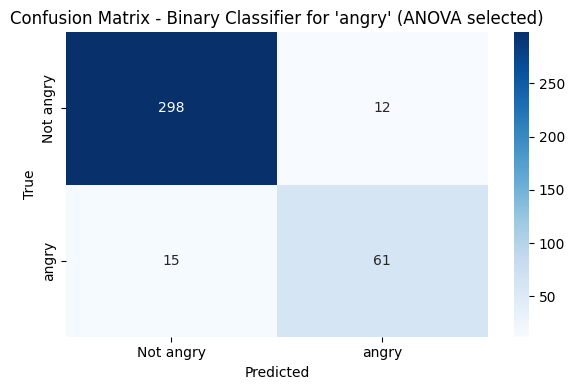

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "angry"

# === Load dataset ===
df = pd.read_csv("openSmile_emobase.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
angry_features = feature_scores[feature_scores.f_score > 10]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(angry_features)} features")

# === Prepare Train/Test ===
X_selected = df[angry_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

angry_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(angry_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    angry_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = angry_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
angry_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = angry_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[disgust] Selected 459 features
Epoch 1: Loss = 11.2006
Epoch 2: Loss = 7.9194
Epoch 3: Loss = 6.5753
Epoch 4: Loss = 5.6217
Epoch 5: Loss = 4.7201
Epoch 6: Loss = 4.1182
Epoch 7: Loss = 3.3520
Epoch 8: Loss = 2.8057
Epoch 9: Loss = 2.0003
Epoch 10: Loss = 1.6645
Epoch 11: Loss = 1.4170
Epoch 12: Loss = 1.5157
Epoch 13: Loss = 1.1378
Epoch 14: Loss = 0.7388
Epoch 15: Loss = 0.8813
Epoch 16: Loss = 0.4522
Epoch 17: Loss = 0.3191
Epoch 18: Loss = 0.2935
Epoch 19: Loss = 0.2244
Epoch 20: Loss = 0.1861
Epoch 21: Loss = 0.1886
Epoch 22: Loss = 0.1270
Epoch 23: Loss = 0.0971
Epoch 24: Loss = 0.0685
Epoch 25: Loss = 0.0435
Epoch 26: Loss = 0.0329
Epoch 27: Loss = 0.0246
Epoch 28: Loss = 0.0195
Epoch 29: Loss = 0.0187
Epoch 30: Loss = 0.0171
Epoch 31: Loss = 0.0141
Epoch 32: Loss = 0.0129
Epoch 33: Loss = 0.0116
Epoch 34: Loss = 0.0109
Epoch 35: Loss = 0.0100
Epoch 36: Loss = 0.0094
Epoch 37: Loss = 0.0090
Epoch 38: Loss = 0.0082
Epoch 39: Loss = 0.0080
Epoch 40: Loss = 0.0085
Epoch 41: Loss =

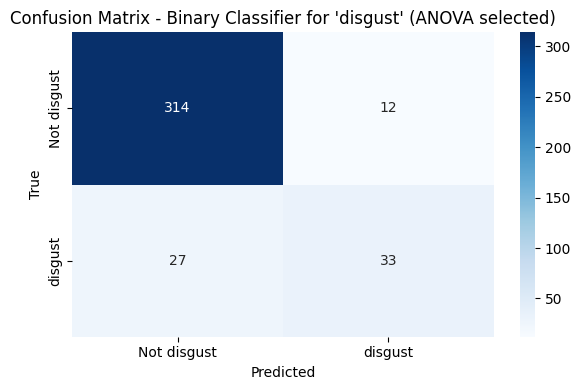

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "disgust"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
disgust_features = feature_scores[feature_scores.f_score > 10]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(disgust_features)} features")

# === Prepare Train/Test ===
X_selected = df[disgust_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

disgust_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(disgust_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    disgust_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = disgust_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
disgust_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = disgust_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[fearful] Selected 589 features
Epoch 1: Loss = 11.6616
Epoch 2: Loss = 8.3428
Epoch 3: Loss = 6.6620
Epoch 4: Loss = 5.0914
Epoch 5: Loss = 3.9925
Epoch 6: Loss = 2.6856
Epoch 7: Loss = 1.8814
Epoch 8: Loss = 1.3860
Epoch 9: Loss = 0.7130
Epoch 10: Loss = 0.4639
Epoch 11: Loss = 0.2363
Epoch 12: Loss = 0.1247
Epoch 13: Loss = 0.0673
Epoch 14: Loss = 0.0486
Epoch 15: Loss = 0.0395
Epoch 16: Loss = 0.0312
Epoch 17: Loss = 0.0273
Epoch 18: Loss = 0.0220
Epoch 19: Loss = 0.0193
Epoch 20: Loss = 0.0180
Epoch 21: Loss = 0.0148
Epoch 22: Loss = 0.0147
Epoch 23: Loss = 0.0124
Epoch 24: Loss = 0.0116
Epoch 25: Loss = 0.0094
Epoch 26: Loss = 0.0088
Epoch 27: Loss = 0.0083
Epoch 28: Loss = 0.0073
Epoch 29: Loss = 0.0067
Epoch 30: Loss = 0.0065
Epoch 31: Loss = 0.0057
Epoch 32: Loss = 0.0054
Epoch 33: Loss = 0.0051
Epoch 34: Loss = 0.0049
Epoch 35: Loss = 0.0045
Epoch 36: Loss = 0.0040
Epoch 37: Loss = 0.0040
Epoch 38: Loss = 0.0036
Epoch 39: Loss = 0.0034
Epoch 40: Loss = 0.0031
Epoch 41: Loss =

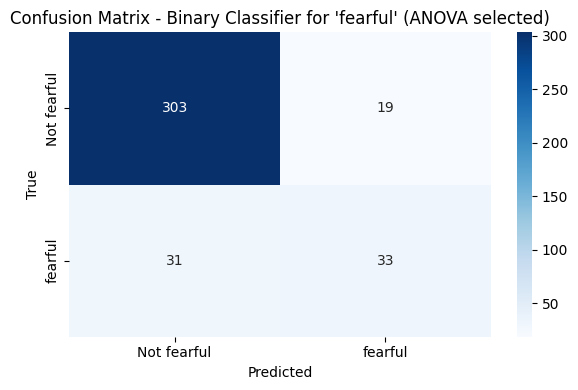

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "fearful"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
fearful_features = feature_scores[feature_scores.f_score > 1]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(fearful_features)} features")

# === Prepare Train/Test ===
X_selected = df[fearful_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

fearful_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(fearful_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    fearful_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = fearful_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
fearful_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = fearful_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[happy] Selected 325 features
Epoch 1: Loss = 11.6637
Epoch 2: Loss = 9.2411
Epoch 3: Loss = 7.9521
Epoch 4: Loss = 7.0000
Epoch 5: Loss = 5.7912
Epoch 6: Loss = 4.8259
Epoch 7: Loss = 3.8562
Epoch 8: Loss = 2.8064
Epoch 9: Loss = 2.1038
Epoch 10: Loss = 1.5423
Epoch 11: Loss = 1.0233
Epoch 12: Loss = 0.5806
Epoch 13: Loss = 0.6503
Epoch 14: Loss = 0.4198
Epoch 15: Loss = 0.1900
Epoch 16: Loss = 0.1228
Epoch 17: Loss = 0.0742
Epoch 18: Loss = 0.0501
Epoch 19: Loss = 0.0389
Epoch 20: Loss = 0.0297
Epoch 21: Loss = 0.0267
Epoch 22: Loss = 0.0212
Epoch 23: Loss = 0.0196
Epoch 24: Loss = 0.0170
Epoch 25: Loss = 0.0150
Epoch 26: Loss = 0.0129
Epoch 27: Loss = 0.0116
Epoch 28: Loss = 0.0104
Epoch 29: Loss = 0.0095
Epoch 30: Loss = 0.0091
Epoch 31: Loss = 0.0080
Epoch 32: Loss = 0.0076
Epoch 33: Loss = 0.0069
Epoch 34: Loss = 0.0065
Epoch 35: Loss = 0.0059
Epoch 36: Loss = 0.0054
Epoch 37: Loss = 0.0052
Epoch 38: Loss = 0.0049
Epoch 39: Loss = 0.0043
Epoch 40: Loss = 0.0042
Epoch 41: Loss = 0

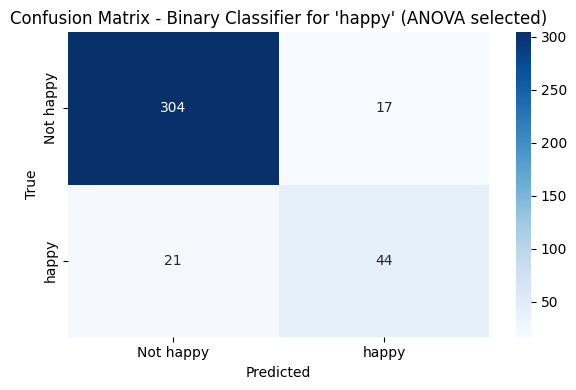

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "happy"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
happy_features = feature_scores[feature_scores.f_score > 9.5]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(happy_features)} features")

# === Prepare Train/Test ===
X_selected = df[happy_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

happy_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(happy_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    happy_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = happy_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
happy_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = happy_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[neutral] Selected 344 features
Epoch 1: Loss = 11.1646
Epoch 2: Loss = 6.4839
Epoch 3: Loss = 5.0587
Epoch 4: Loss = 3.4111
Epoch 5: Loss = 2.6930
Epoch 6: Loss = 2.0573
Epoch 7: Loss = 1.6317
Epoch 8: Loss = 1.0334
Epoch 9: Loss = 0.7630
Epoch 10: Loss = 0.5508
Epoch 11: Loss = 0.3351
Epoch 12: Loss = 0.2528
Epoch 13: Loss = 0.1628
Epoch 14: Loss = 0.1361
Epoch 15: Loss = 0.0693
Epoch 16: Loss = 0.0521
Epoch 17: Loss = 0.0377
Epoch 18: Loss = 0.0323
Epoch 19: Loss = 0.0268
Epoch 20: Loss = 0.0230
Epoch 21: Loss = 0.0200
Epoch 22: Loss = 0.0189
Epoch 23: Loss = 0.0166
Epoch 24: Loss = 0.0155
Epoch 25: Loss = 0.0133
Epoch 26: Loss = 0.0121
Epoch 27: Loss = 0.0117
Epoch 28: Loss = 0.0110
Epoch 29: Loss = 0.0091
Epoch 30: Loss = 0.0083
Epoch 31: Loss = 0.0077
Epoch 32: Loss = 0.0073
Epoch 33: Loss = 0.0072
Epoch 34: Loss = 0.0062
Epoch 35: Loss = 0.0065
Epoch 36: Loss = 0.0054
Epoch 37: Loss = 0.0053
Epoch 38: Loss = 0.0050
Epoch 39: Loss = 0.0047
Epoch 40: Loss = 0.0042
Epoch 41: Loss =

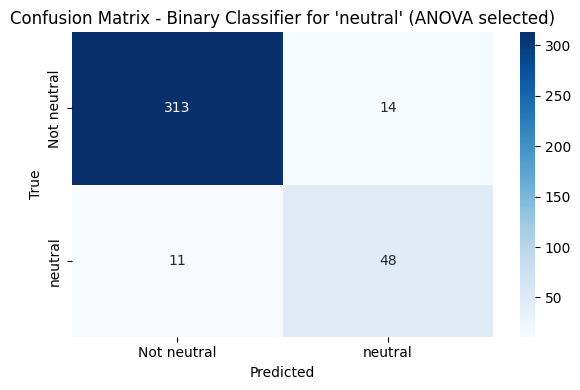

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "neutral"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
neutral_features = feature_scores[feature_scores.f_score > 10]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(neutral_features)} features")

# === Prepare Train/Test ===
X_selected = df[neutral_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

neutral_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(neutral_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    neutral_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = neutral_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
neutral_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = neutral_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [787] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[sad] Selected 578 features
Epoch 1: Loss = 11.4494
Epoch 2: Loss = 8.3072
Epoch 3: Loss = 6.6624
Epoch 4: Loss = 6.0100
Epoch 5: Loss = 5.2272
Epoch 6: Loss = 4.1851
Epoch 7: Loss = 3.0440
Epoch 8: Loss = 2.2163
Epoch 9: Loss = 1.6169
Epoch 10: Loss = 2.4306
Epoch 11: Loss = 1.3200
Epoch 12: Loss = 0.8368
Epoch 13: Loss = 0.5585
Epoch 14: Loss = 0.2437
Epoch 15: Loss = 0.1424
Epoch 16: Loss = 0.1143
Epoch 17: Loss = 0.0718
Epoch 18: Loss = 0.0529
Epoch 19: Loss = 0.0401
Epoch 20: Loss = 0.0345
Epoch 21: Loss = 0.0292
Epoch 22: Loss = 0.0254
Epoch 23: Loss = 0.0234
Epoch 24: Loss = 0.0211
Epoch 25: Loss = 0.0167
Epoch 26: Loss = 0.0157
Epoch 27: Loss = 0.0131
Epoch 28: Loss = 0.0116
Epoch 29: Loss = 0.0102
Epoch 30: Loss = 0.0093
Epoch 31: Loss = 0.0091
Epoch 32: Loss = 0.0106
Epoch 33: Loss = 0.0079
Epoch 34: Loss = 0.0066
Epoch 35: Loss = 0.0060
Epoch 36: Loss = 0.0057
Epoch 37: Loss = 0.0052
Epoch 38: Loss = 0.0046
Epoch 39: Loss = 0.0043
Epoch 40: Loss = 0.0044
Epoch 41: Loss = 0.0

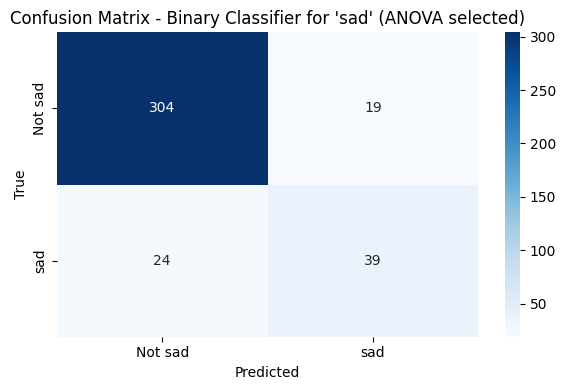

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# === Set target emotion ===
target_emotion = "sad"

# === Load dataset ===
df = pd.read_csv("combined_features.csv")

# === Create binary label: 1 if target, else 0 ===
df["binary_label"] = (df["emotion"] == target_emotion).astype(int)

# === Drop irrelevant columns ===
X = df.drop(columns=["emotion", "binary_label", "filename"], errors="ignore")
y = df["binary_label"]

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === ANOVA Feature Selection (binary) ===
f_scores, p_values = f_classif(X_scaled, y)
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores
})
sad_features = feature_scores[feature_scores.f_score > 5]["feature"].tolist()
print(f"[{target_emotion}] Selected {len(sad_features)} features")

# === Prepare Train/Test ===
X_selected = df[sad_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# === Scale again (for selected features) ===
scaler_sel = StandardScaler()
X_train_scaled = scaler_sel.fit_transform(X_train)
X_test_scaled = scaler_sel.transform(X_test)

# === Convert to PyTorch Tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# === Binary MLP Model ===
class BinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

sad_model = BinaryMLP(X_train_scaled.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(sad_model.parameters(), lr=1e-3)

# === Train ===
for epoch in range(50):
    sad_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = sad_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# === Predict ===
sad_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = sad_model(xb)
        preds = (probs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)

# === Evaluate ===
print(f"\nClassification Report for '{target_emotion}':")
print(classification_report(y_test, all_preds, target_names=["Not " + target_emotion, target_emotion]))

# === Confusion Matrix ===
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not " + target_emotion, target_emotion],
            yticklabels=["Not " + target_emotion, target_emotion])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Binary Classifier for '{target_emotion}' (ANOVA selected)")
plt.tight_layout()
plt.show()


In [22]:
models = {
    "happy": happy_model,
    "angry": angry_model,
    "disgust": disgust_model,
    "fearful": fearful_model,
    "neutral": neutral_model,
    "sad": sad_model,
    #"general": general_model
}
emotion_features = {
    "happy": happy_features,
    "angry": angry_features,
    "disgust": disgust_features,
    "fearful": fearful_features,
    "neutral": neutral_features,
    "sad": sad_features,
    #"general": general_features
}


In [9]:
for model in models.keys():
    print(f"Model for {model}:")
    print(models[model])
    print("\n")

for emotion in emotion_features.keys():
    print(f"Features for {emotion}:")
    print(emotion_features[emotion])
    print("\n")


Model for happy:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=325, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Model for angry:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=574, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Model for disgust:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=459, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Model for fearful:
BinaryMLP(
  (model): Sequential(
    (0): Linear(in_features=589, out_features=128, bias=True)
    (1)

In [23]:
# ─── Block 1: Load & split into train/test DataFrames ───
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load the full CSV
df = pd.read_csv("combined_features.csv")

# 2) Split into train/test *as DataFrames*, stratifying on your label column
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["emotion"],    # replace "emotion" if your label column is named differently
    random_state=42
)

# 3) Isolate features vs. labels for the test set
feature_cols = [c for c in df.columns if c != "emotion"]
df_X = df_test[feature_cols]   # features DataFrame
df_y = df_test["emotion"]      # true‐label Series


In [24]:
# ─── Block 2: Build binary‐output table via each emotion‐model ───
import torch
import pandas as pd

# make sure your models dict and emotion_features dict are already in scope:
# models = { "happy": happy_model, … }
# emotion_features = { "happy": happy_feature_list, … }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []
with torch.no_grad():
    for i in range(len(df_X)):
        row = {}
        sample_series = df_X.iloc[i]          # get the i‑th test row as a Series

        for emotion, model in models.items():
            feat_names = emotion_features[emotion]         
            x_sub      = sample_series[feat_names].values  # grab exactly those columns

            t = (
                torch.tensor(x_sub, dtype=torch.float32)
                     .unsqueeze(0)         # shape [1, input_dim]
                     .to(device)
            )

            model.eval()
            row[emotion] = model(t).item()   # raw sigmoid probability

        row["label"] = df_y.iloc[i]         # append true emotion
        results.append(row)

# final DataFrame
df_binary_outputs = pd.DataFrame(results)
print(df_binary_outputs.head())


   happy  angry  disgust  fearful  neutral  sad    label
0    0.0    0.0      0.0      0.0      0.0  0.0    happy
1    0.0    0.0      0.0      0.0      0.0  0.0    angry
2    0.0    0.0      0.0      0.0      0.0  0.0    angry
3    0.0    0.0      0.0      0.0      0.0  0.0  disgust
4    0.0    0.0      0.0      0.0      0.0  0.0  neutral
